# Setup awal

In [44]:
import os
import numpy as np
import json
import pickle
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch.optim as optim
from torch.optim import AdamW   
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split  
from torch.utils.data import Subset
from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support, ConfusionMatrixDisplay
from sklearn.model_selection import KFold  

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# Dataset

In [46]:
dataset_path = "/kaggle/input/datasetta/Multi-Class Driver Behavior Image Dataset"

kelas = sorted(os.listdir(dataset_path))

jumlah_per_kelas = {}

for k in kelas:
    folder_path = os.path.join(dataset_path, k)
    file_list = [
        f for f in os.listdir(folder_path)
        if f.lower().endswith((".jpg", ".png", ".jpeg"))
    ]
    jumlah_per_kelas[k] = len(file_list)

print("Jumlah gambar per kelas:")
for k, jml in jumlah_per_kelas.items():
    print(f"{k}: {jml}")

Jumlah gambar per kelas:
other_activities: 1184
safe_driving: 1679
talking_phone: 1513
texting_phone: 1561
turning: 1339


# Transformasi gambar

Kelas acak: other_activities
Gambar acak: img_22258.jpg
Path gambar: /kaggle/input/datasetta/Multi-Class Driver Behavior Image Dataset/other_activities/img_22258.jpg


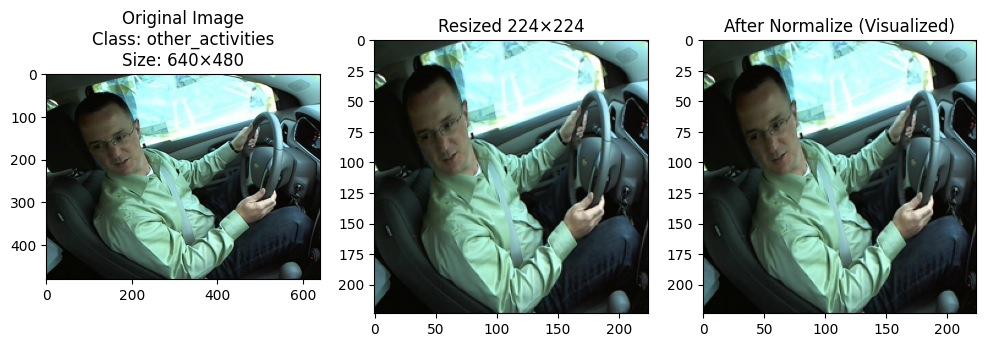

In [47]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ============================
# 1. SET PATH DATASET
# ============================

dataset_path = "/kaggle/input/datasetta/Multi-Class Driver Behavior Image Dataset"

# ambil semua folder kelas
kelas = sorted(os.listdir(dataset_path))

# pilih kelas random
kelas_random = random.choice(kelas)

# pilih gambar random dari kelas itu
gambar_list = os.listdir(os.path.join(dataset_path, kelas_random))
gambar_random = random.choice(gambar_list)

sample_image_path = os.path.join(dataset_path, kelas_random, gambar_random)

print("Kelas acak:", kelas_random)
print("Gambar acak:", gambar_random)
print("Path gambar:", sample_image_path)

# ============================
# 2. LOAD GAMBAR
# ============================

img_original = Image.open(sample_image_path).convert("RGB")
orig_w, orig_h = img_original.size

# resize
img_resized = img_original.resize((224, 224))

# convert ke numpy (0–1)
img_np = np.array(img_resized).astype("float32") / 255.0

# normalize imagenet
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

img_norm = (img_np - mean) / std

# unnormalize untuk visualisasi
img_unnorm = (img_norm * std) + mean
img_unnorm = np.clip(img_unnorm, 0, 1)

# ============================
# 3. PLOT GAMBAR
# ============================

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img_original)
plt.title(f"Original Image\nClass: {kelas_random}\nSize: {orig_w}×{orig_h}")
plt.axis("on")

plt.subplot(1,3,2)
plt.imshow(img_resized)
plt.title("Resized 224×224")
plt.axis("on")

plt.subplot(1,3,3)
plt.imshow(img_unnorm)
plt.title("After Normalize (Visualized)")
plt.axis("on")

plt.show()

# Setup K-folds=5

In [48]:
json_path = '/kaggle/input/kfoldsta/Kfolds_TA.json'

with open(json_path, "r") as f:
    raw = json.load(f)

# Ekstrak meta dan override dataset_path/class_names bila ada
meta = raw.get("meta", {})
if isinstance(meta, dict):
    ds_root = meta.get("dataset_root")
    if ds_root:
        dataset_path = ds_root  # override global dataset path
    if "class_counts" in meta and isinstance(meta["class_counts"], dict):
        class_names = sorted(meta["class_counts"].keys())
    if "n_splits" in meta:
        n_splits = int(meta["n_splits"])
    if "seed" in meta:
        seed = int(meta["seed"])

# Normalisasi folds: ambil semua key selain 'meta'
kfold_splits = {k: v for k, v in raw.items() if k != "meta"}

print("\nPembagian Data K-Fold (dari JSON)")
print(f"Dataset root   : {dataset_path}")
if "class_counts" in meta:
    total_imgs_meta = sum(meta["class_counts"].values())
    print(f"Total gambar   : {total_imgs_meta:,} (dari meta)")
    print("Kelas          : " + ", ".join(class_names))

first_fold_key = next(iter(sorted(kfold_splits.keys())))
first_fold = kfold_splits[first_fold_key]
train_count = len(first_fold.get("train", []))
val_count   = len(first_fold.get("val", []))
total_count = train_count + val_count 

print(f"Jumlah Fold    : {len(kfold_splits)}")
print(f"Train          : {train_count:,} gambar")
print(f"Val            : {val_count:,} gambar")
print(f"Total          : {total_count:,} gambar")


Pembagian Data K-Fold (dari JSON)
Dataset root   : /kaggle/input/datasetta/Multi-Class Driver Behavior Image Dataset
Jumlah Fold    : 5
Train          : 5,820 gambar
Val            : 1,456 gambar
Total          : 7,276 gambar


# Dataset loader untuk memuat gambar dan label

In [49]:
class DriverBehaviorDataset(Dataset):
    def __init__(self, root_dir, file_list, class_to_idx, transform=None):
        self.root_dir = root_dir
        self.file_list = file_list
        self.class_to_idx = class_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        rel_path = self.file_list[idx]
        # Normalisasi path JSON (posix) ke path OS lokal (Windows)
        local_rel = rel_path.replace("/", os.sep)
        img_path = os.path.normpath(os.path.join(self.root_dir, local_rel))

        image = Image.open(img_path).convert('RGB')

        # Ambil label dari segmen folder pertama di path JSON
        class_name = rel_path.split("/", 1)[0]
        label = self.class_to_idx[class_name]

        if self.transform:
            image = self.transform(image)

        return image, label

# Loader dataset berbasis JSON

In [50]:
def load_dataloaders_from_split_json(json_path, dataset_path, fold_name,
                                     batch_size=32, img_size=(224, 224)):
    
    with open(json_path, "r") as f:
        raw = json.load(f)

    meta = raw.get("meta", {})
    ds_root = meta.get("dataset_root") or dataset_path

    # Ambil nama kelas
    if "class_counts" in meta and isinstance(meta["class_counts"], dict):
        class_names = sorted(meta["class_counts"].keys())
    else:
        class_names = sorted(
            [d for d in os.listdir(ds_root)
             if os.path.isdir(os.path.join(ds_root, d))]
        )

    class_to_idx = {cls_name: i for i, cls_name in enumerate(class_names)}

    # Transform image
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Cek fold
    folds_data = {k: v for k, v in raw.items() if k != "meta"}
    if fold_name not in folds_data:
        raise KeyError(f"Fold '{fold_name}' tidak ditemukan di JSON.")

    fold = folds_data[fold_name]
    train_files = fold.get("train", [])
    val_files   = fold.get("val", [])

    # Dataset
    train_dataset = DriverBehaviorDataset(ds_root, train_files, class_to_idx, transform)
    val_dataset   = DriverBehaviorDataset(ds_root, val_files,   class_to_idx, transform)

    # DataLoader
    num_workers = 4
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=True, persistent_workers=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=True, persistent_workers=True)

    return train_loader, val_loader, class_to_idx, class_names, ds_root

# Model

In [51]:
num_classes = len(os.listdir(dataset_path))

def resn18_model(num_classes):
    model = models.resnet18(weights='IMAGENET1K_V1')
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# Training dan evaluasi model resnet 

Training Fold 1
Epoch [1/15] Train Loss: 0.3599 Acc: 0.8711 | Val Loss: 0.1450 Acc: 0.9457
Epoch [2/15] Train Loss: 0.0803 Acc: 0.9706 | Val Loss: 0.1068 Acc: 0.9567
Epoch [3/15] Train Loss: 0.0361 Acc: 0.9871 | Val Loss: 0.1126 Acc: 0.9622
Epoch [4/15] Train Loss: 0.0273 Acc: 0.9928 | Val Loss: 0.1189 Acc: 0.9574
Epoch [5/15] Train Loss: 0.0216 Acc: 0.9938 | Val Loss: 0.1713 Acc: 0.9478
Epoch [6/15] Train Loss: 0.0218 Acc: 0.9942 | Val Loss: 0.1419 Acc: 0.9636
Epoch [7/15] Train Loss: 0.0116 Acc: 0.9974 | Val Loss: 0.1213 Acc: 0.9677
Epoch [8/15] Train Loss: 0.0076 Acc: 0.9985 | Val Loss: 0.1272 Acc: 0.9622
Epoch [9/15] Train Loss: 0.0202 Acc: 0.9954 | Val Loss: 0.1878 Acc: 0.9437
Epoch [10/15] Train Loss: 0.0257 Acc: 0.9928 | Val Loss: 0.2063 Acc: 0.9396
Epoch [11/15] Train Loss: 0.0163 Acc: 0.9957 | Val Loss: 0.1291 Acc: 0.9636
Epoch [12/15] Train Loss: 0.0074 Acc: 0.9990 | Val Loss: 0.1209 Acc: 0.9677
Epoch [13/15] Train Loss: 0.0019 Acc: 0.9997 | Val Loss: 0.1443 Acc: 0.9677
Epoch

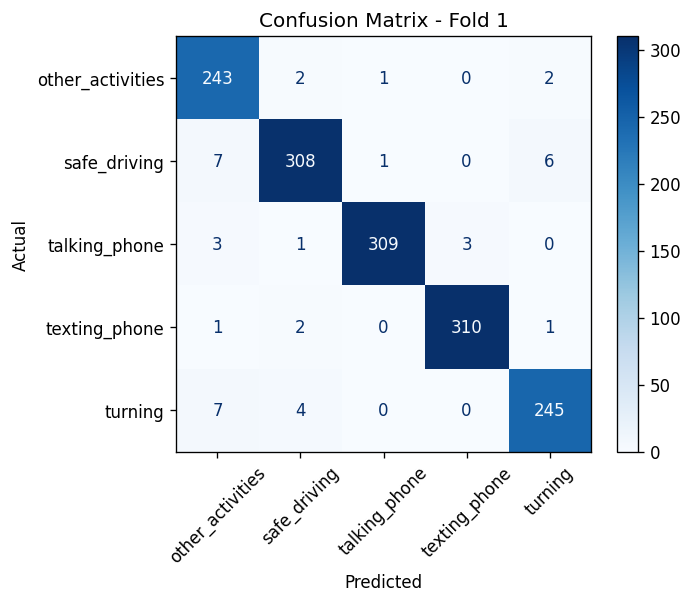

Training Fold 2
Epoch [1/15] Train Loss: 0.3347 Acc: 0.8837 | Val Loss: 0.1510 Acc: 0.9464
Epoch [2/15] Train Loss: 0.0723 Acc: 0.9751 | Val Loss: 0.1309 Acc: 0.9491
Epoch [3/15] Train Loss: 0.0377 Acc: 0.9900 | Val Loss: 0.1235 Acc: 0.9567
Epoch [4/15] Train Loss: 0.0202 Acc: 0.9947 | Val Loss: 0.1689 Acc: 0.9622
Epoch [5/15] Train Loss: 0.0098 Acc: 0.9971 | Val Loss: 0.1517 Acc: 0.9636
Epoch [6/15] Train Loss: 0.0153 Acc: 0.9955 | Val Loss: 0.1552 Acc: 0.9622
Epoch [7/15] Train Loss: 0.0115 Acc: 0.9978 | Val Loss: 0.1807 Acc: 0.9595
Epoch [8/15] Train Loss: 0.0151 Acc: 0.9962 | Val Loss: 0.1720 Acc: 0.9505
Epoch [9/15] Train Loss: 0.0389 Acc: 0.9892 | Val Loss: 0.1802 Acc: 0.9505
Epoch [10/15] Train Loss: 0.0314 Acc: 0.9909 | Val Loss: 0.1671 Acc: 0.9505
Epoch [11/15] Train Loss: 0.0149 Acc: 0.9960 | Val Loss: 0.1917 Acc: 0.9491
Epoch [12/15] Train Loss: 0.0091 Acc: 0.9979 | Val Loss: 0.1427 Acc: 0.9601
Epoch [13/15] Train Loss: 0.0077 Acc: 0.9985 | Val Loss: 0.1514 Acc: 0.9595
Epoch

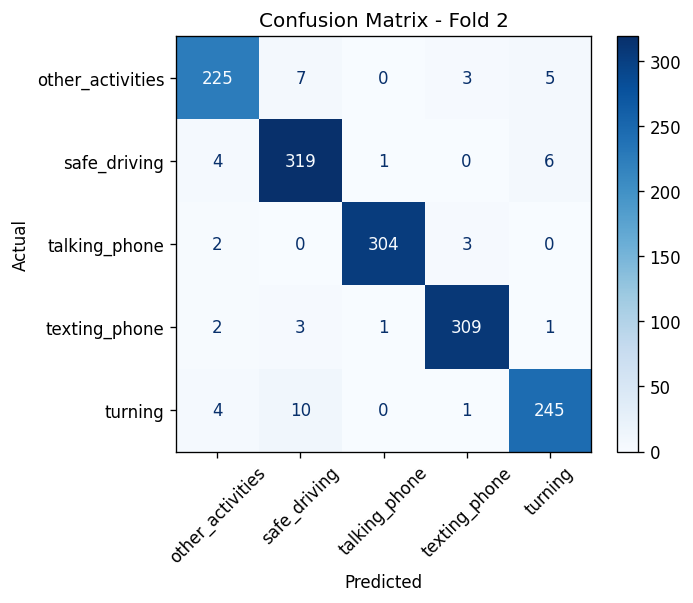

Training Fold 3
Epoch [1/15] Train Loss: 0.3615 Acc: 0.8785 | Val Loss: 0.1616 Acc: 0.9368
Epoch [2/15] Train Loss: 0.0806 Acc: 0.9711 | Val Loss: 0.1151 Acc: 0.9615
Epoch [3/15] Train Loss: 0.0353 Acc: 0.9893 | Val Loss: 0.1195 Acc: 0.9595
Epoch [4/15] Train Loss: 0.0232 Acc: 0.9926 | Val Loss: 0.1486 Acc: 0.9567
Epoch [5/15] Train Loss: 0.0110 Acc: 0.9978 | Val Loss: 0.1579 Acc: 0.9601
Epoch [6/15] Train Loss: 0.0101 Acc: 0.9969 | Val Loss: 0.1508 Acc: 0.9595
Epoch [7/15] Train Loss: 0.0050 Acc: 0.9990 | Val Loss: 0.1971 Acc: 0.9581
Epoch [8/15] Train Loss: 0.0139 Acc: 0.9967 | Val Loss: 0.1939 Acc: 0.9553
Epoch [9/15] Train Loss: 0.0085 Acc: 0.9979 | Val Loss: 0.1843 Acc: 0.9553
Epoch [10/15] Train Loss: 0.0348 Acc: 0.9899 | Val Loss: 0.3175 Acc: 0.8990
Epoch [11/15] Train Loss: 0.0472 Acc: 0.9873 | Val Loss: 0.1542 Acc: 0.9574
Epoch [12/15] Train Loss: 0.0105 Acc: 0.9973 | Val Loss: 0.1761 Acc: 0.9560
Epoch [13/15] Train Loss: 0.0139 Acc: 0.9966 | Val Loss: 0.1393 Acc: 0.9601
Epoch

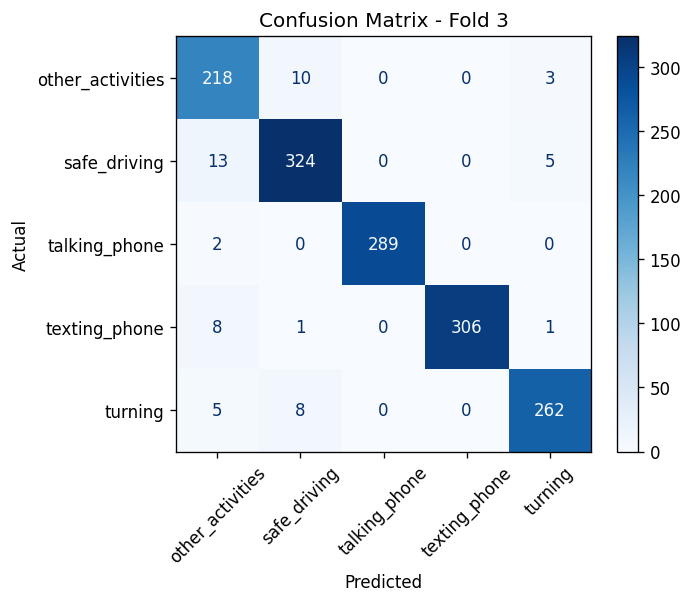

Training Fold 4
Epoch [1/15] Train Loss: 0.3495 Acc: 0.8760 | Val Loss: 0.1767 Acc: 0.9326
Epoch [2/15] Train Loss: 0.0826 Acc: 0.9708 | Val Loss: 0.1348 Acc: 0.9443
Epoch [3/15] Train Loss: 0.0400 Acc: 0.9864 | Val Loss: 0.1673 Acc: 0.9505
Epoch [4/15] Train Loss: 0.0223 Acc: 0.9930 | Val Loss: 0.1663 Acc: 0.9416
Epoch [5/15] Train Loss: 0.0246 Acc: 0.9924 | Val Loss: 0.1595 Acc: 0.9505
Epoch [6/15] Train Loss: 0.0059 Acc: 0.9985 | Val Loss: 0.1913 Acc: 0.9553
Epoch [7/15] Train Loss: 0.0021 Acc: 0.9997 | Val Loss: 0.1830 Acc: 0.9533
Epoch [8/15] Train Loss: 0.0152 Acc: 0.9969 | Val Loss: 0.1798 Acc: 0.9450
Epoch [9/15] Train Loss: 0.0175 Acc: 0.9960 | Val Loss: 0.2203 Acc: 0.9491
Epoch [10/15] Train Loss: 0.0335 Acc: 0.9892 | Val Loss: 0.2052 Acc: 0.9402
Epoch [11/15] Train Loss: 0.0202 Acc: 0.9940 | Val Loss: 0.1885 Acc: 0.9443
Epoch [12/15] Train Loss: 0.0112 Acc: 0.9971 | Val Loss: 0.2071 Acc: 0.9498
Epoch [13/15] Train Loss: 0.0102 Acc: 0.9966 | Val Loss: 0.1757 Acc: 0.9533
Epoch

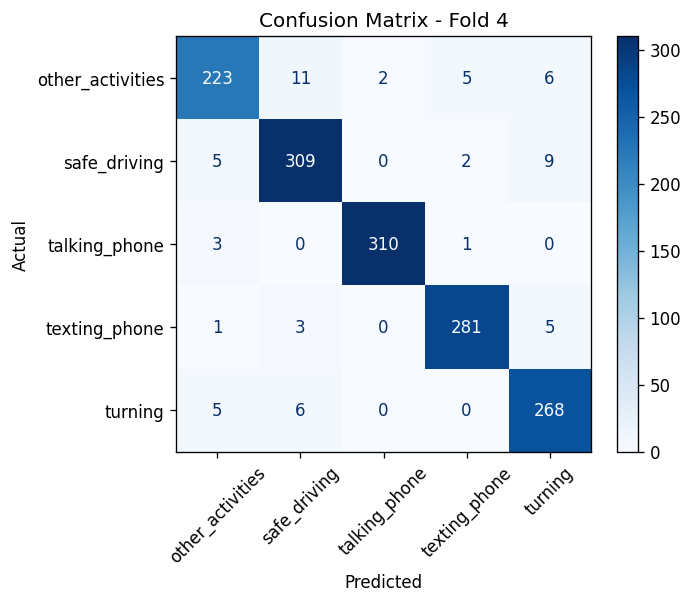

Training Fold 5
Epoch [1/15] Train Loss: 0.3703 Acc: 0.8700 | Val Loss: 0.1176 Acc: 0.9595
Epoch [2/15] Train Loss: 0.0844 Acc: 0.9689 | Val Loss: 0.1003 Acc: 0.9608
Epoch [3/15] Train Loss: 0.0417 Acc: 0.9856 | Val Loss: 0.0881 Acc: 0.9691
Epoch [4/15] Train Loss: 0.0184 Acc: 0.9952 | Val Loss: 0.1026 Acc: 0.9684
Epoch [5/15] Train Loss: 0.0145 Acc: 0.9960 | Val Loss: 0.0987 Acc: 0.9704
Epoch [6/15] Train Loss: 0.0132 Acc: 0.9966 | Val Loss: 0.1055 Acc: 0.9732
Epoch [7/15] Train Loss: 0.0170 Acc: 0.9954 | Val Loss: 0.1151 Acc: 0.9704
Epoch [8/15] Train Loss: 0.0105 Acc: 0.9973 | Val Loss: 0.0993 Acc: 0.9753
Epoch [9/15] Train Loss: 0.0090 Acc: 0.9979 | Val Loss: 0.1478 Acc: 0.9608
Epoch [10/15] Train Loss: 0.0404 Acc: 0.9887 | Val Loss: 0.1552 Acc: 0.9615
Epoch [11/15] Train Loss: 0.0226 Acc: 0.9931 | Val Loss: 0.1068 Acc: 0.9656
Epoch [12/15] Train Loss: 0.0089 Acc: 0.9969 | Val Loss: 0.1163 Acc: 0.9725
Epoch [13/15] Train Loss: 0.0076 Acc: 0.9988 | Val Loss: 0.0977 Acc: 0.9718
Epoch

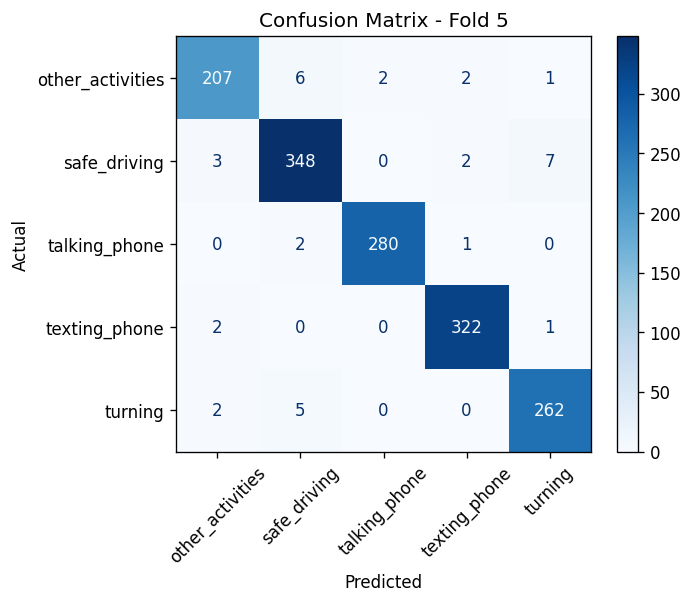

In [52]:
# Hyperparameter
num_epochs = 15
learning_rate = 0.0001

# Dictionary untuk menyimpan hasil semua fold
all_fold_results = {}

# Fungsi training per fold dengan tracking yang lebih detail
def train_fold(fold_name, train_loader, val_loader, num_classes):
    print(f"Training {fold_name.replace('_', ' ').title()}")

    model = resn18_model(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    
    # Track metrics
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_val_acc = 0.0
    best_epoch = 0
    best_model_path = f'{fold_name}_best_model.pth'

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in tqdm(train_loader, disable=True, desc=f"Epoch {epoch+1}/{num_epochs} - Train"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += (outputs.argmax(1) == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_corrects / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        val_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, disable=True, desc=f"Epoch {epoch+1}/{num_epochs} - Val"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += (outputs.argmax(1) == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Track best validation accuracy dan simpan model terbaik
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            torch.save(model.state_dict(), best_model_path)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # Evaluasi pada validation set menggunakan model terbaik
    best_model = resn18_model(num_classes).to(device)
    best_model.load_state_dict(torch.load(best_model_path, map_location=device))
    best_model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = best_model(inputs)
            preds = outputs.argmax(1).detach().cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
    acc = accuracy_score(all_labels, all_preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )
    # Gunakan nama kelas jika tersedia
    if 'class_names' in globals() and len(class_names) == num_classes:
        target_names = [str(c) for c in class_names]
    else:
        target_names = [str(i) for i in range(num_classes)]
    cls_report = classification_report(
        all_labels, all_preds,
        labels=list(range(num_classes)),
        target_names=target_names,
        digits=4, zero_division=0
    )
    print("Evaluasi Model:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | F1-Score: {f1:.4f}")
    print("Classification Report:")
    print(cls_report)

    # Plot confusion matrix
    labels_display = class_names if 'class_names' in globals() else list(range(num_classes))
    fig, ax = plt.subplots(figsize=(6, 5), dpi=120)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_display)
    disp.plot(include_values=True, cmap='Blues', ax=ax, colorbar=True)
    ax.set_title(f'Confusion Matrix - {fold_name.replace("_", " ").title()}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.tick_params(axis='x', labelrotation=45)
    plt.tight_layout()
    plt.show()

    # Simpan hasil fold
    fold_results = {
        'fold_name': fold_name,
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'eval': {
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'confusion_matrix': cm,
            'classification_report': cls_report,
        },
        'best_model_path': best_model_path
    }
    
    # Simpan ke dictionary global
    all_fold_results[fold_name] = fold_results
    
    # Simpan hasil fold ke file
    with open(f'{fold_name}_results.pkl', 'wb') as f:
        pickle.dump(fold_results, f)
    
    return fold_results

def train_all_folds(fold_loaders, num_classes):
    results = {}
    for fold_name, loaders in fold_loaders.items():
        if isinstance(loaders, dict):
            train_loader = loaders.get('train') or loaders.get('train_loader')
            val_loader = loaders.get('val') or loaders.get('val_loader')
        else:
            train_loader, val_loader = loaders
        results[fold_name] = train_fold(fold_name, train_loader, val_loader, num_classes)
    with open('all_folds_results.pkl', 'wb') as f:
        pickle.dump(results, f)
    return results

fold_names = sorted(kfold_splits.keys(), key=lambda n: int(n.split("_")[-1]) if n.split("_")[-1].isdigit() else n)

fold_loaders = {}
class_names = None  
for fold_name in fold_names:
    tr_loader, va_loader, class_to_idx, class_names_local, ds_root = load_dataloaders_from_split_json(
        json_path=json_path,
        dataset_path=dataset_path,
        fold_name=fold_name,
        batch_size=32,
        img_size=(224, 224),
    )
    fold_loaders[fold_name] = {'train': tr_loader, 'val': va_loader}
    if class_names is None:
        class_names = class_names_local
        dataset_path = ds_root  
num_classes = len(class_names)
all_fold_results = train_all_folds(fold_loaders, num_classes)

# Evaluasi rata-rata kfold

In [53]:
print("\n==================== HASIL K-FOLD CROSS VALIDATION ====================\n")

acc_list = []
prec_list = []
rec_list = []
f1_list = []

for fold_name, result in sorted(all_fold_results.items(), key=lambda x: int(x[0].split("_")[-1])):
    acc  = result['eval']['accuracy']
    prec = result['eval']['precision']
    rec  = result['eval']['recall']
    f1   = result['eval']['f1']

    acc_list.append(acc)
    prec_list.append(prec)
    rec_list.append(rec)
    f1_list.append(f1)

    print(f"{fold_name}:")
    print(f"  Accuracy  : {acc:.4f}")
    print(f"  Precision : {prec:.4f}")
    print(f"  Recall    : {rec:.4f}")
    print(f"  F1-Score  : {f1:.4f}")
    print("-" * 60)

# Hitung rata-rata seluruh fold
mean_acc  = np.mean(acc_list)
mean_prec = np.mean(prec_list)
mean_rec  = np.mean(rec_list)
mean_f1   = np.mean(f1_list)

print("\n====================== RATA-RATA 5 FOLD ======================\n")
print(f"Avg Accuracy  : {mean_acc:.4f}")
print(f"Avg Precision : {mean_prec:.4f}")
print(f"Avg Recall    : {mean_rec:.4f}")
print(f"Avg F1-Score  : {mean_f1:.4f}")


==================== HASIL K-FOLD CROSS VALIDATION ====================

fold_1:
  Accuracy  : 0.9718
  Precision : 0.9702
  Recall    : 0.9717
  F1-Score  : 0.9708
------------------------------------------------------------
fold_2:
  Accuracy  : 0.9636
  Precision : 0.9630
  Recall    : 0.9616
  F1-Score  : 0.9623
------------------------------------------------------------
fold_3:
  Accuracy  : 0.9615
  Precision : 0.9595
  Recall    : 0.9611
  F1-Score  : 0.9600
------------------------------------------------------------
fold_4:
  Accuracy  : 0.9560
  Precision : 0.9553
  Recall    : 0.9541
  F1-Score  : 0.9546
------------------------------------------------------------
fold_5:
  Accuracy  : 0.9753
  Precision : 0.9751
  Recall    : 0.9741
  F1-Score  : 0.9746
------------------------------------------------------------

====================== RATA-RATA 5 FOLD ======================

Avg Accuracy  : 0.9656
Avg Precision : 0.9646
Avg Recall    : 0.9645
Avg F1-Score  : 0.9645


# Evaluasi menggunakan data test

In [60]:
# FUNGSI VALIDASI 
def validate(model, dataloader, criterion, device="cuda"):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    if len(dataloader.dataset) == 0:
        print("⚠ Dataset validation kosong!")
        return 0, 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            try:
                images, labels = batch
            except Exception as e:
                print(f"❌ Error membaca batch {batch_idx}: {e}")
                continue

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    if total_samples == 0:
        return 0, 0

    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    return avg_loss, avg_acc



# VALIDATION LOOP                          
criterion = nn.CrossEntropyLoss()
val_results = {}

for fold_name in fold_loaders.keys():

    print(f"\n=== Evaluasi Validation Set: {fold_name} ===")

    # Load model terbaik per fold 
    model_path = f"/kaggle/working/{fold_name}_best_model.pth"

    model = models.resnet18(weights='DEFAULT')
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    model = model.to(device)

    # Load checkpoint
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()

    # Ambil val loader
    val_loader = DataLoader(
        fold_loaders[fold_name]["val"].dataset,
        batch_size=fold_loaders[fold_name]["val"].batch_size,
        shuffle=False,
        num_workers=2,            
        pin_memory=False
    )

    # Hitung loss & akurasi
    val_loss, val_acc = validate(model, val_loader, criterion, device=device)

    val_results[fold_name] = {
        "loss": val_loss,
        "acc": val_acc
    }

    print(f"Validation Loss : {val_loss:.4f}")
    print(f"Validation Acc  : {val_acc * 100:.2f}%")


mean_acc  = np.mean([v["acc"]  for v in val_results.values()])
mean_loss = np.mean([v["loss"] for v in val_results.values()])

print("\n=== RATA-RATA VALIDATION SET ===")
print(f"Avg Loss : {mean_loss:.4f}")
print(f"Avg Acc  : {mean_acc * 100:.2f}%")



=== Evaluasi Validation Set: fold_1 ===
Validation Loss : 0.1263
Validation Acc  : 97.18%

=== Evaluasi Validation Set: fold_2 ===
Validation Loss : 0.1517
Validation Acc  : 96.36%

=== Evaluasi Validation Set: fold_3 ===
Validation Loss : 0.1151
Validation Acc  : 96.15%

=== Evaluasi Validation Set: fold_4 ===
Validation Loss : 0.2039
Validation Acc  : 95.60%

=== Evaluasi Validation Set: fold_5 ===
Validation Loss : 0.0993
Validation Acc  : 97.53%

=== RATA-RATA VALIDATION SET ===
Avg Loss : 0.1393
Avg Acc  : 96.56%


# Visualisasi akurasi tiap fold

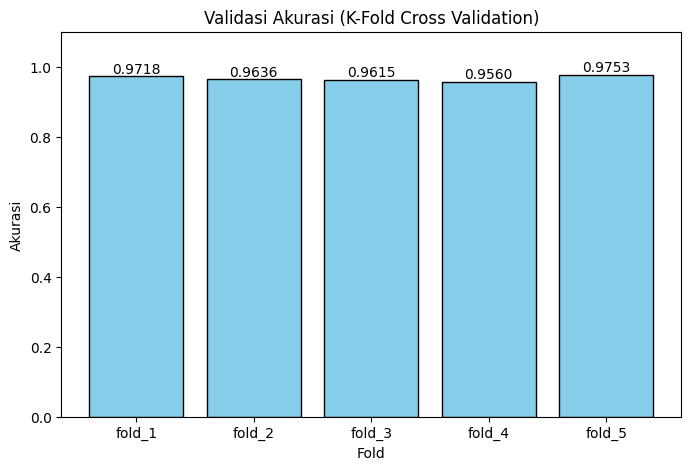

In [63]:
with open("/kaggle/working/all_folds_results.pkl", "rb") as f:
    all_fold_results = pickle.load(f)

fold_names = list(all_fold_results.keys())
accuracies = [v['eval']['accuracy'] for v in all_fold_results.values()]

# Pastikan data tidak kosong
if len(accuracies) == 0:
    print("⚠️ Tidak ada data akurasi di file all_fold_results.pkl. Pastikan training sudah selesai dengan benar.")
else:
    # === 3️⃣ Visualisasi dengan diagram batang ===
    plt.figure(figsize=(8,5))
    bars = plt.bar(fold_names, accuracies, color='skyblue', edgecolor='black')
    plt.title("Validasi Akurasi (K-Fold Cross Validation)")
    plt.xlabel("Fold")
    plt.ylabel("Akurasi")
    plt.ylim(0, 1.1)

    # Tambahkan nilai akurasi di atas setiap batang
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, acc + 0.01, f"{acc:.4f}", ha='center', fontsize=10)

    plt.show()

# Visualisasi kurva per epoch

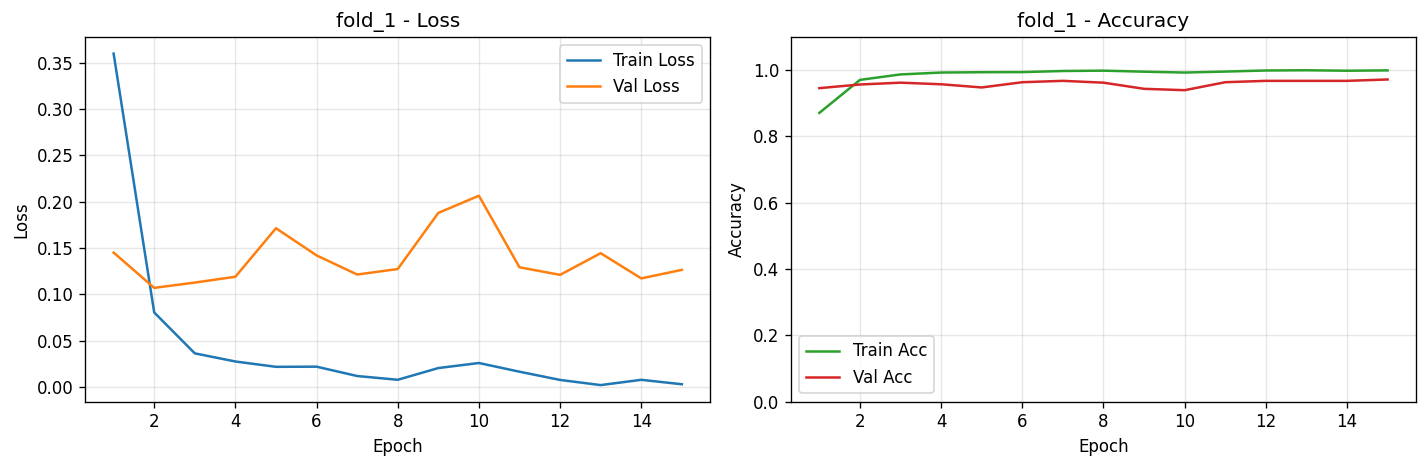

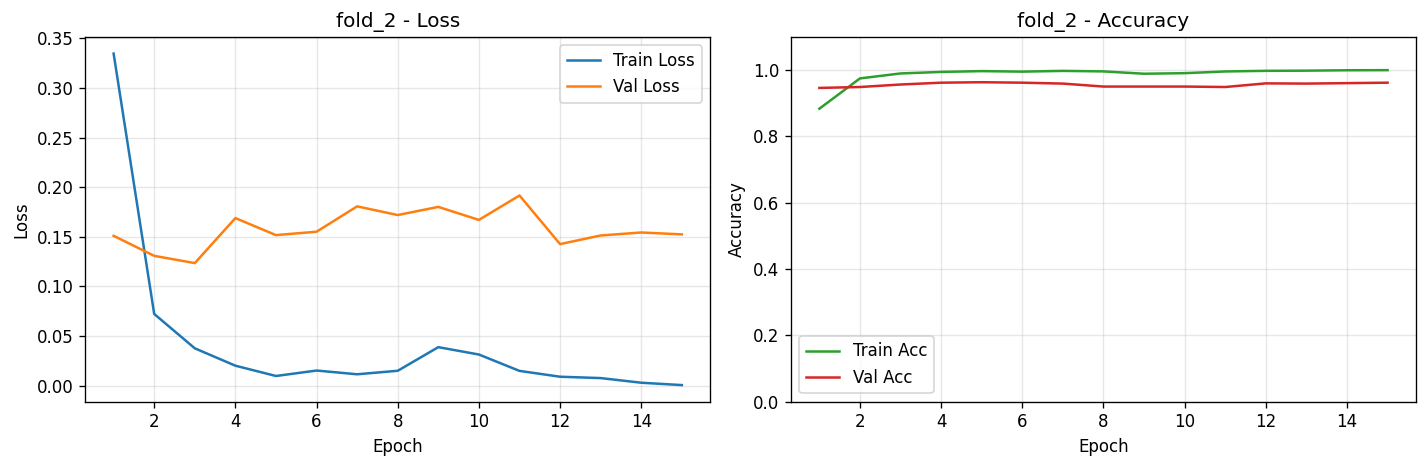

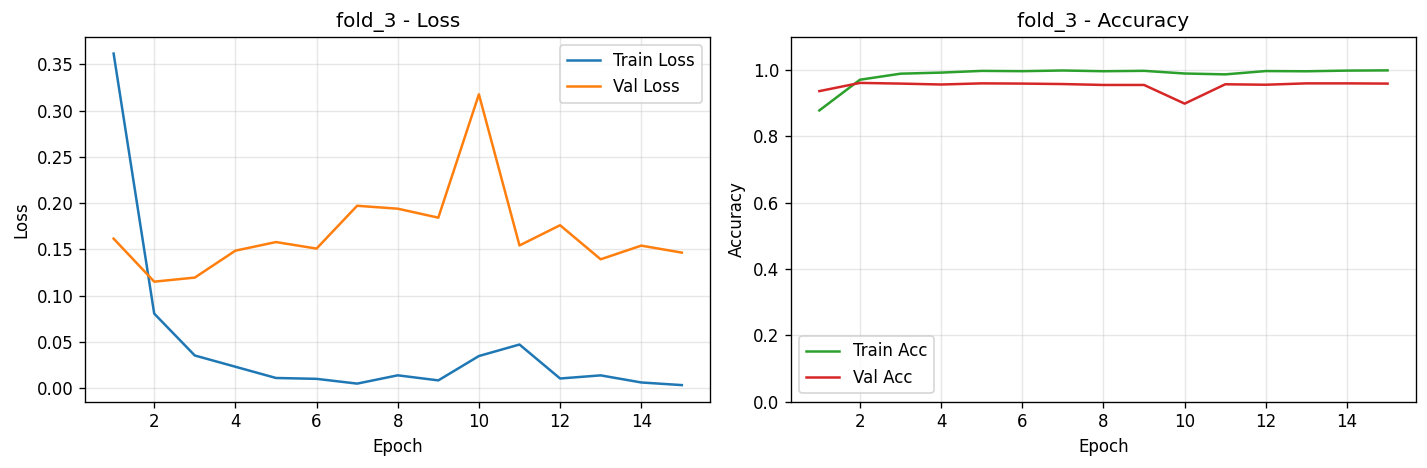

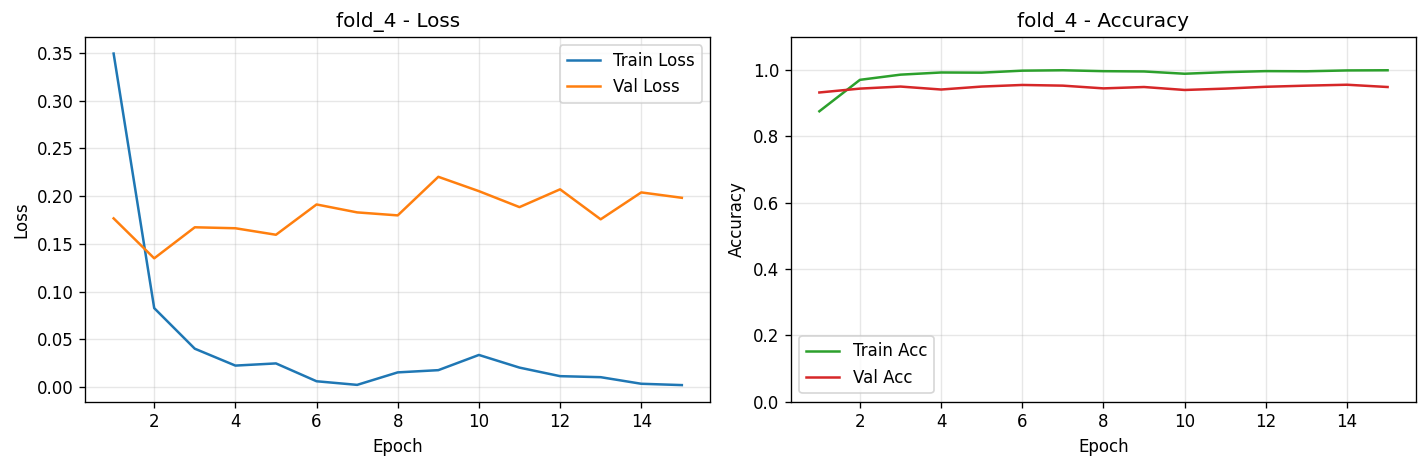

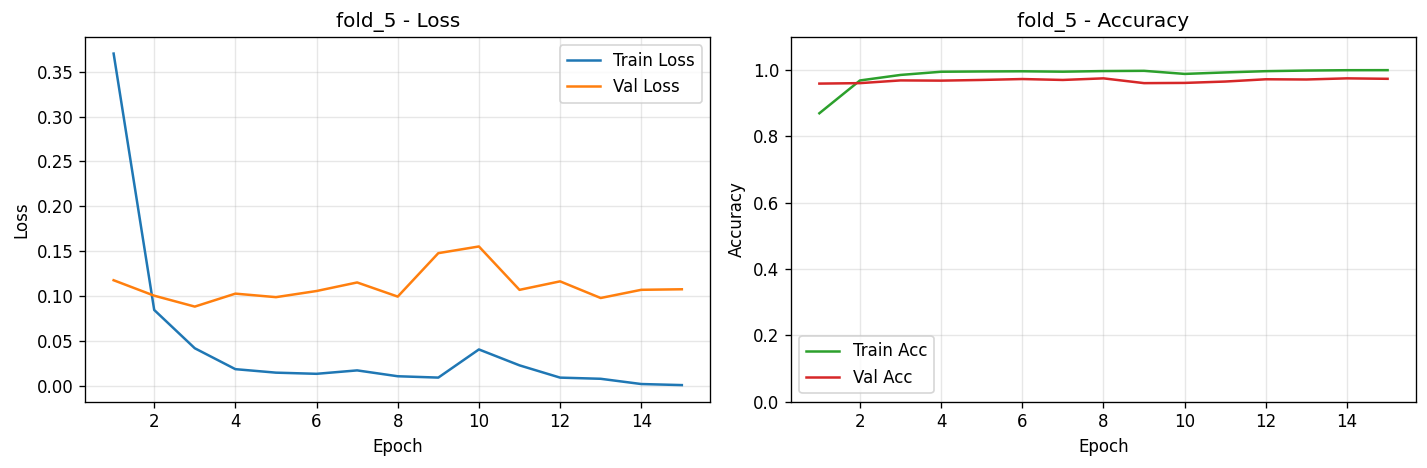

In [65]:
# Visualisasi hasil training setiap fold

def _collect_fold_results():
    results = {}
    # 1) Ambil dari variabel global jika sudah ada
    if 'all_fold_results' in globals() and isinstance(all_fold_results, dict) and len(all_fold_results) > 0:
        results.update(all_fold_results)
    return results

def _fold_sort_key(name):
    # Coba ekstrak angka urutan dari nama fold (misal "fold_3" -> 3)
    parts = name.replace('-', '_').split('_')
    for p in parts:
        if p.isdigit():
            return int(p)
    return 0

fold_results = _collect_fold_results()
if not fold_results:
    print("Tidak ditemukan hasil training fold. Jalankan training terlebih dahulu.")
else:
    # Urutkan fold agar rapi
    fold_names_sorted = sorted(fold_results.keys(), key=_fold_sort_key)

    # Plot per fold: kurva Loss dan Accuracy
    for fold_name in fold_names_sorted:
        fr = fold_results[fold_name]
        train_losses = fr.get('train_losses', [])
        val_losses = fr.get('val_losses', [])
        train_accs = fr.get('train_accs', [])
        val_accs = fr.get('val_accs', [])

        epochs = range(1, len(train_losses) + 1) if train_losses else range(1, len(val_losses) + 1)

        fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=120)
        # Loss
        axes[0].plot(epochs, train_losses, label='Train Loss', color='tab:blue')
        axes[0].plot(epochs, val_losses, label='Val Loss', color='tab:orange')
        axes[0].set_title(f'{fold_name} - Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].grid(True, alpha=0.3)
        axes[0].legend()

        # Accuracy
        axes[1].plot(epochs, train_accs, label='Train Acc', color='tab:green')
        axes[1].plot(epochs, val_accs, label='Val Acc', color='tab:red')
        axes[1].set_title(f'{fold_name} - Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_ylim(0, 1.1)
        axes[1].grid(True, alpha=0.3)
        axes[1].legend()

        plt.tight_layout()
        plt.show()